-100 100
-100 100
23.606797749978952 100
-23.606797749978952 100
-23.606797749978952 23.60679774997898
5.572809000084131 23.60679774997898
5.572809000084131 12.461179749810738
9.830056250525768 12.461179749810738
9.830056250525768 10.835055998654067
10.45118025355414 10.835055998654067
10.45118025355414 10.59780774072562
10.541801024311104 10.59780774072562
10.541801024311104 10.563193686383173
10.555022416581483 10.563193686383173
10.555022416581483 10.558143563914482
10.556951391717172 10.558143563914482
10.556951391717172 10.557406760976102
10.557232825396623 10.557406760976102
10.557232825396623 10.55729926287613
10.557273886017086 10.55729926287613
[21.0]


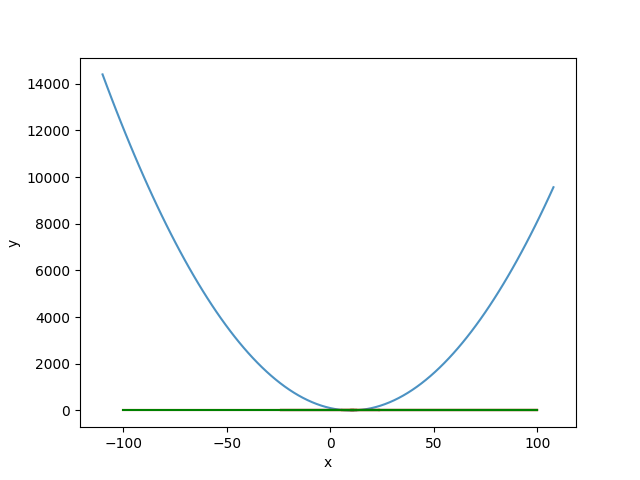

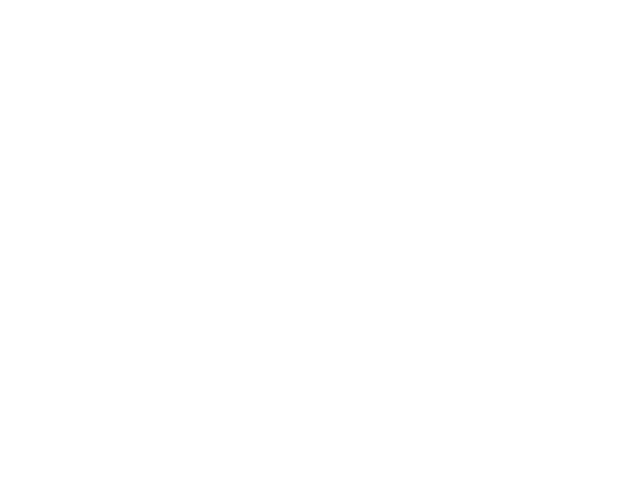

In [1]:
%matplotlib widget
from src.metric import CallCount
from src.common.oracul import LambdaOracul

from src.lab1.stop_condition import CountCondition, PrecisionCondition
import numpy as np
from src.common import Oracul, Point
from src.lab1.method_processor import MethodProcessor
from src.lab1.methods import RandomMethod, GoldenRatioMethod

import matplotlib.pyplot as plt

fig = plt.figure()

method = RandomMethod()
golden_ratio = GoldenRatioMethod()
oracul = LambdaOracul(lambda x: (x - 10) ** 2, 2)
point, metrics, anim = MethodProcessor.process(golden_ratio, oracul, CountCondition(20), metrics=[CallCount()], method_params = {"a":-100, "b":100}, visualize=True,
                                              low_bracket=[-100], high_bracket=[100])
print(metrics)
plt.show()